In [0]:
import pandas as pd
import numpy as np
import ast
import csv
import time

from operator import itemgetter
import networkx as nx
from networkx.algorithms import community

import matplotlib.pyplot as plt

In [78]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
users=np.zeros((40000,1))

In [26]:
users.shape

(40000, 1)

In [0]:
user_friends={}
user_tags={}
max_friends=0
min_friends=200000
def hasMoreTags(s):
    return s[-1]!=']'

# Generate User: Tags dict

In [33]:
start=time.time()
with open('/content/drive/My Drive/data.csv', 'r') as infile:
    reader = csv.reader(infile)
    count=-1
    
    for row in reader:
        #print(row[:7])
        count += 1
        if count == 0:
            continue
        id=row[0]
        #print(count)
        users[count-1][0]=id
        screenName=row[1]
        
        many_tags=hasMoreTags(row[2])
        
        offset=0
        #print('{} originally'.format(row[2]))
        #print(row[3])
        if many_tags:
            this_tags=[]
            for j in range(20):
                this_tags.append(row[2+j].strip('[]').strip(''))
                if row[2+j][-1]==']':
                    break
            #print('{} many tags'.format(this_tags))
            user_tags[id]=this_tags
            offset=len(this_tags)-1
            #print(offset)
        else:
            user_tags[id]=row[2].strip('[]').strip('')
            
        #followersCount=row[4]
        #print(offset)
        friendsCount=int(row[5+offset])
        #print(row[5+offset])
        max_friends=max(max_friends,friendsCount)
        min_friends=min(min_friends,friendsCount)
        friends=row[9+offset:]
        friends[0]=friends[0].strip('[]')
        friends[-1]=friends[-1].strip('[]')
        friends=[i.replace('"', '') for i in friends]
        friends=[i.strip() for i in friends]
        user_friends[id]=friends
        #print("{} : {}".format(count, friends))
end=time.time()
print('{} seconds'.format(end-start))

28.920035123825073 seconds


In [34]:
print(max_friends)
print(min_friends)

238749
101


# Generate/Read all tags

In [0]:
import re
def remove_hashtag(raw_str):
  return ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)"," ",raw_str).split())

In [0]:
try:
  all_tags=pd.read_csv('/content/drive/My Drive/all_tags_saved.csv')
except:
  all_tags=set()

  for u in user_tags:
    tags=user_tags[u]

    if type(tags) == str:
      all_tags.add(remove_hashtag(tags))
    else:
      for tag in tags:
        all_tags.add(remove_hashtag(tag))

  pd.DataFrame(list(all_tags)).to_csv('/content/drive/My Drive/all_tags_saved.csv')

In [29]:
len(all_tags)

128

# Generate Tag: User dict

In [0]:
tag_users={}

In [0]:
for u in user_tags:
  tags=user_tags[u]
  if type(tags)==str:
    normalized_tag=remove_hashtag(tags)
    if normalized_tag in tag_users:
      cur_tags=tag_users[normalized_tag]
      cur_tags.append(u)
      tag_users[normalized_tag]=cur_tags
    else:
      cur_tags=[]
      cur_tags.append(u)
      tag_users[normalized_tag]=cur_tags
  else:
    for tag in tags:
      normalized_tag=remove_hashtag(tag)
      if normalized_tag in tag_users:
        cur_tags=tag_users[normalized_tag]
        cur_tags.append(u)
        tag_users[normalized_tag]=cur_tags
      else:
        cur_tags=[]
        cur_tags.append(u)
        tag_users[normalized_tag]=cur_tags

In [37]:
len(tag_users)

128

In [0]:
tag_nums=pd.DataFrame({'tags':x,'num':y})

In [0]:
x=list(tag_users.keys())

In [0]:
y=[len(item) for item in tag_users.values()]

In [46]:
# Sort by the num of each tag
sorted_tag_nums=tag_nums.sort_values(by=['num'], ascending=[0])
sorted_tag_nums[:10]

,tags,num
0,nationaldogday,30513
17,respecttylerjoseph,6054
2,gloryoutnow,600
8,backtohogwarts,310
1,narcos,269
76,steve rogers,211
31,louisweloveyou,142
24,bournemouth,130
69,bundesliga,122
27,harry potter,103


In [0]:
sorted_x=sorted_tag_nums['tags'][:5]
sorted_y=sorted_tag_nums['num'][:5]

In [63]:
list(sorted_x)

['nationaldogday',
 'respecttylerjoseph',
 'gloryoutnow',
 'backtohogwarts',
 'narcos']

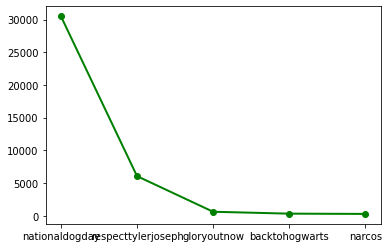

In [52]:
plt.plot(sorted_x, sorted_y,'go-', label='line 1', linewidth=2)

In [0]:
# Generate the nodes and edges
nodes=user_friends.keys()
len(nodes)

40000

In [0]:
node_list=list(nodes)
with open('/content/drive/My Drive/nodelist.txt', 'w') as filehandle:
    for listitem in node_list:
        filehandle.write('%s\n' % listitem)

In [0]:
def calculate_shortest_dist(this_tag):
  count=1
  for a in k_nodes:

    no_paths=[]
    shortest_path_list=[]
    shortest_dist=[]

    for b in k_nodes:
      if a==b:
        continue

      try:
        s_path=nx.shortest_path_length(G,a,b)
        shortest_path_list.append((a,b,s_path))
        shortest_dist.append(s_path)

      except:
        no_paths.append((a,b))

    with open('/content/drive/My Drive/%s_shortest_path.txt'%this_tag,'a+') as fp:
        fp.write('\n'.join('%s %s %s'%x for x in shortest_path_list))

    with open('/content/drive/My Drive/%s_no_path.txt'%this_tag,'a+') as fp:
        fp.write('\n'.join('%s %s'%x for x in no_paths))

    with open('/content/drive/My Drive/%s_shortest_dist.txt'%this_tag,'a+') as fp:
        fp.write('\n'.join('%s'%x for x in shortest_dist))

    #print('Finished {} node'.format(count))
    count+=1

In [66]:
# Calculate Six Degree under the same tag 'nationaldogday'
# Step 1: Get the intersaction
top_tags=list(sorted_x)

# Sample 200 user from top 5 tags to calculate 6 degree
k=200


for this_tag in top_tags:
  this_tag_users=set(tag_users[this_tag])
  this_tag_users_list=list(this_tag_users)
  k_nodes=[]

  for i in range(k):
    n1=random.choice(this_tag_users_list)
    k_nodes.append(n1)

  calculate_shortest_dist(this_tag)

Finished 1 node
Finished 2 node
Finished 3 node
Finished 4 node
Finished 5 node
Finished 6 node
Finished 7 node
Finished 8 node
Finished 9 node
Finished 10 node
Finished 11 node
Finished 12 node
Finished 13 node
Finished 14 node
Finished 15 node
Finished 16 node
Finished 17 node
Finished 18 node
Finished 19 node
Finished 20 node
Finished 21 node
Finished 22 node
Finished 23 node
Finished 24 node
Finished 25 node
Finished 26 node
Finished 27 node
Finished 28 node
Finished 29 node
Finished 30 node
Finished 31 node
Finished 32 node
Finished 33 node
Finished 34 node
Finished 35 node
Finished 36 node
Finished 37 node
Finished 38 node
Finished 39 node
Finished 40 node
Finished 41 node
Finished 42 node
Finished 43 node
Finished 44 node
Finished 45 node
Finished 46 node
Finished 47 node
Finished 48 node
Finished 49 node
Finished 50 node
Finished 51 node
Finished 52 node
Finished 53 node
Finished 54 node
Finished 55 node
Finished 56 node
Finished 57 node
Finished 58 node
Finished 59 node
Finish

In [81]:
# Analyze top 5 tags
for this_tag in top_tags:

   shortest_dist_list = pd.read_csv('/content/drive/My Drive/%s_shortest_dist.txt'%this_tag, names=['dist'], sep=" ", header=None)

   print(this_tag)
   shortest_dist_list['dist'].value_counts().to_csv('/content/drive/My Drive/%s_info.txt'%this_tag,sep=':')
   shortest_dist_list.describe().to_csv('/content/drive/My Drive/%s_info.txt'%this_tag, mode='a',sep=':')

nationaldogday
respecttylerjoseph
gloryoutnow
backtohogwarts
narcos


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  


In [5]:
begin=time.time()
try:
  # nx.write_gpickle(G,"test.gpickle")
  # Read from pickle
  G=nx.read_gpickle("/content/drive/My Drive/test.gpickle")
  end=time.time()
  print('Spent {} in reading graph'.format(end-begin))
except:
  G=nx.Graph()
  G.add_edges_from(edges)
  end=time.time()
  print('{} seconds'.format(end-start))

Spent 117.97631311416626 in reading graph


In [0]:
len(common_users)

30513

In [0]:
node_list=[line.rstrip('\n') for line in open('/content/drive/My Drive/nodelist.txt')]

In [9]:
import random
# Calculate the shortest path
#################### Select k nodes #####################

k=1000
k_nodes=[]

for i in range(k):

  n1=random.choice(node_list)
  k_nodes.append(n1)

print('Finished sampling')
#remain_nodes=list(set(nodes)-set(k_nodes))

pairs_count=0
count=1
for a in k_nodes:

  no_paths=[]
  shortest_path_list=[]
  shortest_dist=[]

  for b in k_nodes:
    if a==b:
      continue

    pairs_count+=1

    try:
      s_path=nx.shortest_path_length(G,a,b)
      shortest_path_list.append((a,b,s_path))
      shortest_dist.append(s_path)

    except:
      no_paths.append((a,b))

  with open('/content/drive/My Drive/shortest_path.txt','a+') as fp:
      fp.write('\n'.join('%s %s %s'%x for x in shortest_path_list))

  with open('/content/drive/My Drive/no_path.txt','a+') as fp:
      fp.write('\n'.join('%s %s'%x for x in no_paths))

  with open('/content/drive/My Drive/shortest_dist.txt','a+') as fp:
      fp.write('\n'.join('%s'%x for x in shortest_dist))

  #print('finished {} node'.format(count))
  count+=1

Finished sampling
finished 1 node
finished 2 node
finished 3 node
finished 4 node
finished 5 node
finished 6 node
finished 7 node
finished 8 node
finished 9 node
finished 10 node
finished 11 node
finished 12 node
finished 13 node
finished 14 node
finished 15 node
finished 16 node
finished 17 node
finished 18 node
finished 19 node
finished 20 node
finished 21 node
finished 22 node
finished 23 node
finished 24 node
finished 25 node
finished 26 node
finished 27 node
finished 28 node
finished 29 node
finished 30 node
finished 31 node
finished 32 node
finished 33 node
finished 34 node
finished 35 node
finished 36 node
finished 37 node
finished 38 node
finished 39 node
finished 40 node
finished 41 node
finished 42 node
finished 43 node
finished 44 node
finished 45 node
finished 46 node
finished 47 node
finished 48 node
finished 49 node
finished 50 node
finished 51 node
finished 52 node
finished 53 node
finished 54 node
finished 55 node
finished 56 node
finished 57 node
finished 58 node
finis

In [0]:
shortest_dist_list = pd.read_csv('/content/drive/My Drive/shortest_dist.txt', names=['dist'], sep=" ", header=None)

In [22]:
shortest_dist_list['dist'].value_counts()

2     464969
3     371718
4     150003
5       9872
22       552
6        260
1        170
23       155
32       153
42        41
33        39
24        33
43         9
34         6
52         4
44         3
25         3
35         1
Name: dist, dtype: int64

In [24]:
shortest_dist_list.describe()

,dist
count,997991.000000
mean,2.727120
std,1.060507
min,1.000000
25%,2.000000
50%,3.000000
75%,3.000000
max,52.000000


In [0]:
# Generate the edges
start=time.time()
edges=[]

for u in user_friends:
    for v in user_friends[u]:
        edges.append(tuple((u,v)))
end=time.time()
print('{} seconds'.format(end-start))

10.898245811462402 seconds


In [0]:
# edges

In [0]:
len(edges)

In [0]:
# Save edges
with open('/content/drive/My Drive/twitter_edges.edgelist', 'w') as fp:
    fp.write('\n'.join('%s %s' % x for x in edges))

In [0]:
print(nx.info(G))